# dAiv AI_Competition[2024]_Pro Baseline for PyTorch

## Import Libraries

In [1]:
from os import path, rename, mkdir, listdir

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, utils, models
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

datasets.utils.tqdm = tqdm
%matplotlib inline

### Check GPU Availability

In [2]:
!nvidia-smi

Fri Oct 18 08:40:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |    679MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 5

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [4]:
from typing import Callable, Optional
from sklearn.model_selection import train_test_split


class ImageDataset(datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_pro/dataset/archive.zip"
    random_state = 20241028

    def __init__(
            self, root: str, force_download: bool = True,
            train: bool = False, valid: bool = False, split_ratio: float = 0.8,
            test: bool = False, unlabeled: bool = False,
            transform: Optional[Callable] = None, target_transform: Optional[Callable] = None
    ):
        self.download(root, force=force_download)  # Download Dataset from server

        if train or valid:  # Set-up directory
            root = path.join(root, "train")
        else:
            root = path.join(root, "test" if test else "unlabeled" if unlabeled else None)

        # Initialize ImageFolder
        super().__init__(root=root, transform=transform, target_transform=target_transform)

        if train or valid:  # Split Train and Validation Set
            seperated = train_test_split(
                self.samples, self.targets, test_size=1-split_ratio, stratify=self.targets, random_state=self.random_state
            )
            self.samples, self.targets = (seperated[0], seperated[2]) if train else (seperated[1], seperated[3])
            self.imgs = self.samples

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "archive.zip")):
            # Download and Extract Dataset
            datasets.utils.download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="archive.zip")
            
            # Arrange Dataset Directory
            for target_dir in [path.join(root, "test"), path.join(root, "unlabeled")]:
                for file in listdir(target_dir):
                    mkdir(path.join(target_dir, file.replace(".jpg", "")))
                    rename(path.join(target_dir, file), path.join(target_dir, file.replace(".jpg", ""), file))

            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

### Dataset Initialization

In [5]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (256, 256)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [6]:
DATA_ROOT = path.join(".", "data")

train_dataset = ImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = ImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)

test_dataset = ImageDataset(root=DATA_ROOT, force_download=False, test=True, transform=resizer)
unlabeled_dataset = ImageDataset(root=DATA_ROOT, force_download=False, unlabeled=True, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)}), Unlabeled({len(unlabeled_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(7478), Valid(1870), Test(1110), Unlabeled(380)


### Visualize Dataset Distribution
    - for checking...

In [7]:
from collections import Counter

def dist_visualizer(dataset, title: str):
    counter = Counter(dataset.targets)
    labels, values = zip(*sorted(counter.items()))

    plt.figure(figsize=(8, 2))
    plt.bar(labels, values)
    plt.title(title)
    plt.show()

In [8]:
# Label Check
for i, label in zip(range(5), train_dataset.targets):
    print(i, "-", train_dataset.classes[label])

0 - 050.Pelagic_Cormorant
1 - 020.Leonberger
2 - 104.Black_capped_Vireo
3 - 020.Leonberger
4 - 009.Siamese


In [9]:
# Data Check
for i, image in zip(range(2), train_dataset.samples):
    print(i, "-", *train_dataset[i], image[0])

0 - tensor([[[ 0.5364,  0.5536,  0.5536,  ...,  0.7419,  0.7077,  0.7077],
         [ 0.5364,  0.5536,  0.5536,  ...,  0.7419,  0.7077,  0.7077],
         [ 0.5536,  0.5536,  0.5536,  ...,  0.7419,  0.7248,  0.7248],
         ...,
         [ 1.3070,  1.1872,  1.1358,  ...,  0.9988,  1.1015,  0.8104],
         [ 1.2043,  1.1872,  1.1015,  ...,  0.7419,  0.6392,  0.4851],
         [ 1.0844,  1.1187,  1.0673,  ...,  0.7248,  0.6734,  1.0331]],

        [[ 0.3978,  0.4153,  0.4328,  ...,  0.5028,  0.4678,  0.4328],
         [ 0.3978,  0.4153,  0.4153,  ...,  0.5028,  0.4853,  0.4503],
         [ 0.3803,  0.3803,  0.4153,  ...,  0.5028,  0.4853,  0.4503],
         ...,
         [ 1.0455,  0.9230,  0.8880,  ...,  0.7829,  0.8704,  0.5553],
         [ 0.9755,  0.9580,  0.9055,  ...,  0.5553,  0.3627,  0.1176],
         [ 0.8529,  0.9055,  0.8880,  ...,  0.5378,  0.3803,  0.6779]],

        [[ 0.2348,  0.2348,  0.2522,  ...,  0.3045,  0.2522,  0.1999],
         [ 0.2173,  0.2348,  0.2348,  ...

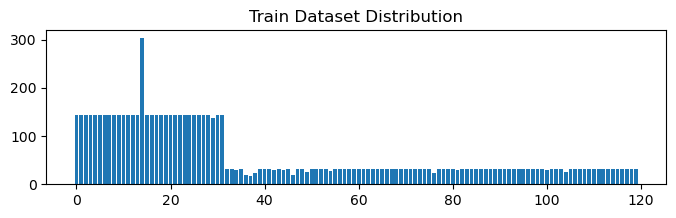

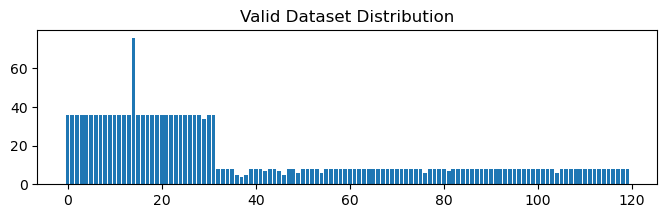

In [10]:
# Distribution
dist_visualizer(train_dataset, "Train Dataset Distribution")
dist_visualizer(valid_dataset, "Valid Dataset Distribution")

## Data Augmentation if needed

In [11]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [12]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer
])

In [13]:
train_dataset = ImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(7478)


## DataLoader

In [14]:
# Set Batch Size
BATCH_SIZE = 128

In [15]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


In [16]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = np.array(image_list).transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)

In [17]:
# images, targets = next(iter(train_loader))
# grid_images = utils.make_grid(images, nrow=8, padding=10)
# imshow(grid_images)

## Define Model

In [18]:
from torch.autograd import Function

class GradientReversal(Function):
    @staticmethod
    def forward(ctx, x, lambda_grl):
        ctx.lambda_grl = lambda_grl
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_grl, None


In [19]:
class SecondMaxLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.clone()
        max_val, max_idx = torch.max(x, dim=1, keepdim=True)
        x.scatter_(1, max_idx, 1e-12)
        return x

In [20]:
class ImageClassifier(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, adaptive_pool_size: int, img_size: int, num_classes: int):
        super().__init__()
        self.multiple_output = False

        # 특징 추출기 (ResNet 백본)
        self.resnet = models.resnet34(pretrained=True)
        self.fc_size = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.fc_size, adaptive_pool_size)

        # 도메인 분류기 - 복잡한 도메인 분류를 위한 다층 퍼셉트론(MLP)
        self.domain_classifier = nn.Sequential(
            nn.Linear(adaptive_pool_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

        # 출력 레이어 - 최종 예측을 위한 메인 분류기
        self.classifier = nn.Linear(adaptive_pool_size, num_classes)

        # 멀티라벨 분류를 위한 보조 분류기 (필요할 경우 사용)
        self.secondary = SecondMaxLayer()

    def toggle_multilabel(self, multi_label: bool | None = None):
        """싱글 라벨과 멀티 라벨 분류 사이를 전환하는 함수."""
        if isinstance(multi_label, bool):
            self.multiple_output = multi_label
        else:
            self.multiple_output = not self.multiple_output

    def forward(self, x, lambda_grl=1.0):
        # ResNet을 통한 특징 추출
        extracted = self.resnet(x)
    
        # 메인 분류기의 출력
        out = self.classifier(extracted)
    
        # GRL 적용 후 도메인 분류기 통과
        reversed_feature = GradientReversal.apply(extracted, lambda_grl)
        domain = torch.sigmoid(self.domain_classifier(reversed_feature))
    
        # 멀티라벨 출력이 활성화된 경우
        if self.multiple_output:
            return domain, out, self.secondary(out)
    
        # 도메인과 메인 분류기 출력 반환
        return domain, out

In [21]:
CLASS_LABELS = len(train_dataset.classes)

MODEL_PARAMS = dict(
    input_channel=3, output_channel=64, adaptive_pool_size=512,
    img_size=IMG_SIZE[0], num_classes=CLASS_LABELS
)

In [22]:
# Initialize Model
model = ImageClassifier(**MODEL_PARAMS)
model.to(device)

/shared_hdd/rnoro5122/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared_hdd/rnoro5122/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ImageClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [23]:
LEARNING_RATE = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

## Training Loop

In [24]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [25]:
# Set Epoch Count
num_epochs = 10

In [26]:
train_length, valid_length = map(len, (train_loader, valid_loader))
unlabeled_length = len(unlabeled_loader)

# 손실 함수 정의
domain_criterion = nn.BCELoss()  # 도메인 분류 손실 함수

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
      tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        model.toggle_multilabel(False)

        unlabeled_iter = iter(unlabeled_loader)  # 타겟 도메인 데이터 로더의 이터레이터 생성

        for i, (inputs_source, targets_source) in enumerate(train_loader):
            optimizer.zero_grad()

            # 소스 도메인 데이터 설정
            inputs_source, targets_source = inputs_source.to(device), targets_source.to(device)
            domain_label_source = torch.zeros(inputs_source.size(0), 1).to(device)  # 소스 도메인 레이블: 0

            # 타겟 도메인 데이터 가져오기
            try:
                inputs_target, _ = next(unlabeled_iter)  # 타겟 도메인 데이터 가져오기, 레이블은 없음
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                inputs_target, _ = next(unlabeled_iter)
            inputs_target = inputs_target.to(device)
            domain_label_target = torch.ones(inputs_target.size(0), 1).to(device)  # 타겟 도메인 레이블: 1

            # lambda_grl 값 설정 (필요에 따라 조정하거나 스케줄링 가능)
            lambda_grl = 1.0

            # 모델 출력 계산
            # 소스 도메인 데이터에서 분류와 도메인 분류 출력
            domain_outputs_source, outputs_source = model(inputs_source, lambda_grl)
            # 타겟 도메인 데이터에서 도메인 분류 출력 (레이블 없음)
            domain_outputs_target, _ = model(inputs_target, lambda_grl)

            # 손실 함수 계산
            # 분류 손실 (소스 도메인 데이터에 대해서만)
            classification_loss = criterion(outputs_source, targets_source)

            # 도메인 분류 손실 (소스와 타겟 도메인 모두)
            domain_outputs = torch.cat([domain_outputs_source, domain_outputs_target], dim=0)
            domain_labels = torch.cat([domain_label_source, domain_label_target], dim=0)
            domain_classification_loss = domain_criterion(domain_outputs, domain_labels)

            # 총 손실 계산 (분류 손실 + 도메인 분류 손실)
            loss = classification_loss + domain_classification_loss

            # 역전파 및 옵티마이저 스텝
            loss.backward()
            optimizer.step()

            # # 도메인 분류 정확도 계산
            # domain_preds = (domain_outputs >= 0.5).float()
            # domain_acc = (domain_preds == domain_labels).sum().item() / domain_labels.size(0)

            # Progress Bar 업데이트 및 출력
            update(loss)
            train_progress.update(1)
            print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{i+1:2}/{train_length}], Loss: {loss.item():.6f}", end="")
            # print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{i+1:2}/{train_length}], Loss: {loss.item():.6f}, Domain Acc: {domain_acc:.6%}", end="")

        val_acc, val_loss, val_domain_acc = 0, 0, 0

        # Validation
        model.eval()
        model.toggle_multilabel(False)
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                domain_outputs, outputs = model(inputs)

                # 분류 손실 계산
                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum().item() / len(valid_dataset)

                # 도메인 분류기 정확도 계산
                domain_preds = (domain_outputs >= 0.5).float()
                domain_labels = torch.ones(inputs.size(0), 1).to(device)  # Validation 데이터는 타겟 도메인으로 가정
                val_domain_acc += (domain_preds == domain_labels).sum().item() / domain_labels.size(0)

                valid_progress.update(1)

        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}, Domain Acc: {val_domain_acc:.6%}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")

Running Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Output()

Epoch [ 1/10], Step [ 5/59], Loss: 5.127808

KeyboardInterrupt: 

In [ ]:
if not path.isdir(path.join(".", "models")):
    mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"baseline_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Model Evaluation

In [ ]:
# Load Model
model_id = "baseline_model"

model = ImageClassifier(**MODEL_PARAMS)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
results = dict(id=[], label1=[], label2=[])
test_length = len(test_dataset)

model.eval()
model.toggle_multilabel(True)
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        domain, outputs1, outputs2 = model(inputs)

        # label1 처리
        preds1 = []
        for i in range(domain.size(0)):
            if domain[i].item() <= 0.52:
                preds1.append(-1)  # 도메인 분류기가 소스 도메인으로 예측하면 -1 저장
            else:
                # 도메인 분류기가 타겟 도메인으로 예측하면 멀티라벨 추론 수행
                pred = torch.max(outputs2[i], 0)[1].item()
                preds1.append(pred)

        # label2는 그대로 멀티라벨 분류 결과 사용
        preds2 = torch.max(outputs1, 1)[1]

        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label1'] += preds1
        results['label2'] += preds2.cpu().detach().numpy().tolist()

In [ ]:
# Re-arrange Results
for i, labels in enumerate(zip(results['label1'], results['label2'])):
    results['label1'][i], results['label2'][i] = min(labels), max(labels)
    # results['label1'][i], results['label2'][i] = -1, results['label1'][i]  # 멀티 라벨 분류 안하고 그냥 '-1, 라벨'로 처리

results_df = pd.DataFrame(results)
results_df

In [ ]:
# Save Results
submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)